In [7]:
import matplotlib.pyplot as plt
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import deepxde as dde
import numpy as np
import time
#from deepxde.backend import tf

In [8]:
n_f = 10000
n_u = 200 # split to 50-50 later

In [9]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1) #0.99
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [10]:
def pde(x, u): # x: x,t vector. u: output
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t + u * du_x - 0.01 / np.pi * du_xx

In [11]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [12]:
import warnings
warnings.filterwarnings('ignore')

data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=n_f, num_boundary=100, num_initial=100)

In [18]:
import warnings
warnings.filterwarnings('ignore')

# AUTOMATIC SCRIPT
n_f = 10000
interval = 1e-7
start = 1e-7
gtols = []
for i in range(5):
    for i in range(10):
        gtols.append(start)
        start += interval
    interval *= 10

out_times = []
out_mses = []

for i,gtol in enumerate(gtols): # 50 iterations
    print(f'=={i+1}/50==gtol:{gtol}=========================')
    # Settings
    dde.optimizers.set_LBFGS_options(maxiter=10000,gtol=gtol)
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=20)
    
    data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=n_f, num_boundary=100, num_initial=100) # 200 boundary
    net = dde.nn.FNN([2] + [40] * 8 + [1], "tanh", "Glorot normal") # 40 neurons (Raissi)
    model = dde.Model(data, net)
    model.compile("L-BFGS") 
    
    # TIME
    start = time.time()
    losshistory, train_state = model.train(callbacks = [early_stopping])
    end = time.time()
    out_times.append(end-start)
    print(f"--Train took {end-start} seconds----------------")

    # EVALUATE
    X, u_true = gen_fea_data(x,t,u)
    u_pred = model.predict(X)
    mse = dde.metrics.mean_squared_error(u_true, u_pred)
    out_mses.append(mse)
    print(f"--MSE: {mse}----------------")
    
out_times_np = np.array(out_times)
out_mses_np = np.array(out_mses)

np.save('vanilla_times_mses2',np.array([out_times_np,out_mses_np]))

==1/50==gtol:1e-07=========================
Compiling model...
'compile' took 0.199138 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.53e-02, 2.45e-02, 4.80e-01]    [7.53e-02, 2.45e-02, 4.80e-01]    []  


KeyboardInterrupt: 

In [21]:
import warnings
warnings.filterwarnings('ignore')

# AUTOMATIC SCRIPT
interval = 1e-7
start = 1e-7
gtols = []
for i in range(5):
    for i in range(10):
        gtols.append(start)
        start += interval
    interval *= 10

n_f_list = [1500, 5000, 10000]#, 15000,20000]
n_b_list = [1, 25, 50, 100, 200, 400]

for n_f in n_f_list:
    for n_b in n_b_list:
        print(f"###### {n_f} domain points, {n_b*2} boundary points ######")
        out_times = []
        out_mses = []

        for i,gtol in enumerate(gtols): # 50 iterations
            print(f'=={i+1}/50==gtol:{gtol}=========================')
            # Settings
            dde.optimizers.set_LBFGS_options(maxiter=10000,gtol=gtol)
            early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=20)

            data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                                num_domain=n_f, num_boundary=n_b, num_initial=n_b) # 200 boundary
            net = dde.nn.FNN([2] + [40] * 8 + [1], "tanh", "Glorot normal") # 40 neurons (Raissi)
            model = dde.Model(data, net)
            model.compile("L-BFGS") 

            # TIME
            start = time.time()
            losshistory, train_state = model.train(callbacks = [early_stopping])
            end = time.time()
            out_times.append(end-start)
            print(f"--Train took {end-start} seconds----------------")

            # EVALUATE
            X, u_true = gen_fea_data(x,t,u)
            u_pred = model.predict(X)
            mse = dde.metrics.mean_squared_error(u_true, u_pred)
            out_mses.append(mse)
            print(f"--MSE: {mse}----------------")

        out_times_np = np.array(out_times)
        out_mses_np = np.array(out_mses)

        np.save(f'vanilla_times_mses_{n_f}nf{n_b}nb',np.array([out_times_np,out_mses_np]))

###### 1500 domain points, 2 boundary points ######
==1/50==gtol:1e-07=========================
Compiling model...
'compile' took 0.001950 s

Training model...

0         [6.51e-03, 2.37e-02, 0.00e+00]    [6.51e-03, 2.37e-02, 0.00e+00]    []  
368       [1.73e-08, 1.82e-14, 1.91e-13]    [1.73e-08, 1.82e-14, 1.91e-13]    []  
369       [1.73e-08, 1.82e-14, 1.91e-13]    [1.73e-08, 1.82e-14, 1.91e-13]    []  
370       [1.73e-08, 1.82e-14, 1.91e-13]    [1.73e-08, 1.82e-14, 1.91e-13]    []  
371       [1.73e-08, 1.82e-14, 1.91e-13]    [1.73e-08, 1.82e-14, 1.91e-13]    []  
372       [1.73e-08, 1.82e-14, 1.91e-13]    [1.73e-08, 1.82e-14, 1.91e-13]    []  
373       [1.73e-08, 1.82e-14, 1.91e-13]    [1.73e-08, 1.82e-14, 1.91e-13]    []  
374       [1.73e-08, 1.82e-14, 1.91e-13]    [1.73e-08, 1.82e-14, 1.91e-13]    []  
375       [1.73e-08, 1.82e-14, 1.91e-13]    [1.73e-08, 1.82e-14, 1.91e-13]    []  
376       [1.73e-08, 1.82e-14, 1.91e-13]    [1.73e-08, 1.82e-14, 1.91e-13]    []  
377      

1067      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1068      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1069      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1070      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1071      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1072      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1073      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1074      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1075      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1076      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1077      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1078      [5.13e-08, 9.89e-14, 6.80e-14]    [5.13e-08, 9.89e-14, 6.80e-14]    []  
1079

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.45e-01, 1.11e-01, 0.00e+00]    [1.45e-01, 1.11e-01, 0.00e+00]    []  
67        [1.10e-07, 3.53e-16, 1.02e-13]    [1.10e-07, 3.53e-16, 1.02e-13]    []  

Best model at step 67:
  train loss: 1.10e-07
  test loss: 1.10e-07
  test metric: []

'train' took 0.785046 s

--Train took 0.7853350639343262 seconds----------------
--MSE: 0.3783695930173139----------------
==13/50==gtol:3.1e-06=========================
Compiling model...
'compile' took 0.000161 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.10e-01, 1.24e-01, 0.00e+00]    [1.10e-01, 1.24e-01, 0.00e+00]    []  
59        [2.61e-07, 3.51e-12, 2.27e-12]    [2.61e-07, 3.51e-12, 2.27e-12]    []  

Best model at step 59:
  train loss: 2.61e-07
  test loss: 2.61e-07
  test metric: []

'train' took 0.672251 s

--Train took 0.6726911067962646 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.89e-03, 5.62e-02, 0.00e+00]    [1.89e-03, 5.62e-02, 0.00e+00]    []  
24        [8.45e-07, 2.48e-10, 3.33e-12]    [8.45e-07, 2.48e-10, 3.33e-12]    []  

Best model at step 24:
  train loss: 8.45e-07
  test loss: 8.45e-07
  test metric: []

'train' took 0.238341 s

--Train took 0.23862886428833008 seconds----------------
--MSE: 0.3795896799634816----------------
==27/50==gtol:7.11e-05=========================
Compiling model...
'compile' took 0.000159 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.95e-02, 1.63e-02, 0.00e+00]    [4.95e-02, 1.63e-02, 0.00e+00]    []  
28        [3.14e-06, 4.93e-09, 3.21e-09]    [3.14e-06, 4.93e-09, 3.21e-09]    []  

Best model at step 28:
  train loss: 3.15e-06
  test loss: 3.15e-06
  test metric: []

'train' took 0.279177 s

--Train took 0.2794508934020996

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.72e-01, 1.56e-02, 0.00e+00]    [2.72e-01, 1.56e-02, 0.00e+00]    []  
7         [7.09e-05, 2.44e-07, 1.45e-08]    [7.09e-05, 2.44e-07, 1.45e-08]    []  

Best model at step 7:
  train loss: 7.12e-05
  test loss: 7.12e-05
  test metric: []

'train' took 0.082513 s

--Train took 0.08278799057006836 seconds----------------
--MSE: 0.37593290082937025----------------
==41/50==gtol:0.0011111000000000003=========================
Compiling model...
'compile' took 0.000162 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.31e-02, 4.99e-02, 0.00e+00]    [2.31e-02, 4.99e-02, 0.00e+00]    []  
4         [1.37e-04, 8.28e-07, 1.25e-06]    [1.37e-04, 8.28e-07, 1.25e-06]    []  

Best model at step 4:
  train loss: 1.39e-04
  test loss: 1.39e-04
  test metric: []

'train' took 0.057618 s

--Train took 0.0579

5500      [1.99e-06, 1.32e-08, 1.38e-07]    [1.99e-06, 1.32e-08, 1.38e-07]    []  
5501      [1.99e-06, 1.32e-08, 1.38e-07]    [1.99e-06, 1.32e-08, 1.38e-07]    []  
5502      [1.99e-06, 1.32e-08, 1.38e-07]    [1.99e-06, 1.32e-08, 1.38e-07]    []  
Epoch 5502: early stopping

Best model at step 5486:
  train loss: 2.14e-06
  test loss: 2.14e-06
  test metric: []

'train' took 98.308369 s

--Train took 98.30873203277588 seconds----------------
--MSE: 0.005519708188490992----------------
==2/50==gtol:2e-07=========================
Compiling model...
'compile' took 0.000174 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.10e-03, 2.83e-02, 3.82e-01]    [4.10e-03, 2.83e-02, 3.82e-01]    []  
1000      [1.30e-04, 1.70e-06, 6.11e-05]    [1.30e-04, 1.70e-06, 6.11e-05]    []  
2000      [1.91e-05, 3.96e-07, 1.57e-06]    [1.91e-05, 3.96e-07, 1.57e-06]    []  
3000      [5.85e-06, 2.89e-08, 3.81e-07]    [5.85e-06, 2.89e-

4337      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4338      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4339      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4340      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4341      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4342      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4343      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4344      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4345      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4346      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4347      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4348      [6.40e-07, 1.03e-08, 5.19e-08]    [6.40e-07, 1.03e-08, 5.19e-08]    []  
4349

4171      [1.35e-06, 9.34e-09, 8.81e-08]    [1.35e-06, 9.34e-09, 8.81e-08]    []  
Epoch 4171: early stopping

Best model at step 4154:
  train loss: 1.45e-06
  test loss: 1.45e-06
  test metric: []

'train' took 74.230104 s

--Train took 74.23045778274536 seconds----------------
--MSE: 0.013704938938071006----------------
==10/50==gtol:1e-06=========================
Compiling model...
'compile' took 0.000175 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.27e-02, 4.82e-02, 3.49e-01]    [1.27e-02, 4.82e-02, 3.49e-01]    []  
1000      [1.61e-04, 1.61e-06, 1.33e-04]    [1.61e-04, 1.61e-06, 1.33e-04]    []  
2000      [2.26e-05, 7.37e-08, 2.45e-06]    [2.26e-05, 7.37e-08, 2.45e-06]    []  
3000      [3.75e-06, 5.90e-08, 5.07e-07]    [3.75e-06, 5.90e-08, 5.07e-07]    []  
4000      [1.34e-06, 1.50e-08, 9.83e-08]    [1.34e-06, 1.50e-08, 9.83e-08]    []  
4238      [1.17e-06, 1.92e-08, 7.69e-08]    [1.17e-06, 1.92e

5072      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5073      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5074      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5075      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5076      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5077      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5078      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5079      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5080      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5081      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5082      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5083      [9.40e-07, 1.21e-08, 2.62e-08]    [9.40e-07, 1.21e-08, 2.62e-08]    []  
5084

4060      [1.23e-06, 5.81e-09, 5.45e-08]    [1.23e-06, 5.81e-09, 5.45e-08]    []  
4061      [1.23e-06, 5.81e-09, 5.45e-08]    [1.23e-06, 5.81e-09, 5.45e-08]    []  
4062      [1.23e-06, 5.81e-09, 5.45e-08]    [1.23e-06, 5.81e-09, 5.45e-08]    []  
4063      [1.23e-06, 5.81e-09, 5.45e-08]    [1.23e-06, 5.81e-09, 5.45e-08]    []  
Epoch 4063: early stopping

Best model at step 4046:
  train loss: 1.29e-06
  test loss: 1.29e-06
  test metric: []

'train' took 72.987555 s

--Train took 72.98807144165039 seconds----------------
--MSE: 9.199075376760905e-06----------------
==17/50==gtol:7.099999999999999e-06=========================
Compiling model...
'compile' took 0.000287 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.26e-03, 1.76e-04, 5.04e-01]    [1.26e-03, 1.76e-04, 5.04e-01]    []  
1000      [6.87e-05, 1.10e-06, 1.44e-05]    [6.87e-05, 1.10e-06, 1.44e-05]    []  
2000      [6.50e-06, 4.51e-08, 6.13e-07]   

4973      [2.62e-06, 1.19e-08, 2.92e-07]    [2.62e-06, 1.19e-08, 2.92e-07]    []  
4974      [2.62e-06, 1.19e-08, 2.92e-07]    [2.62e-06, 1.19e-08, 2.92e-07]    []  
4975      [2.62e-06, 1.19e-08, 2.92e-07]    [2.62e-06, 1.19e-08, 2.92e-07]    []  
4976      [2.62e-06, 1.19e-08, 2.92e-07]    [2.62e-06, 1.19e-08, 2.92e-07]    []  
4977      [2.62e-06, 1.19e-08, 2.92e-07]    [2.62e-06, 1.19e-08, 2.92e-07]    []  
4978      [2.62e-06, 1.19e-08, 2.92e-07]    [2.62e-06, 1.19e-08, 2.92e-07]    []  
4979      [2.62e-06, 1.19e-08, 2.92e-07]    [2.62e-06, 1.19e-08, 2.92e-07]    []  
4980      [2.62e-06, 1.19e-08, 2.92e-07]    [2.62e-06, 1.19e-08, 2.92e-07]    []  
4981      [2.62e-06, 1.19e-08, 2.92e-07]    [2.62e-06, 1.19e-08, 2.92e-07]    []  
4982      [2.62e-06, 1.19e-08, 2.92e-07]    [2.62e-06, 1.19e-08, 2.92e-07]    []  
Epoch 4982: early stopping

Best model at step 4965:
  train loss: 2.93e-06
  test loss: 2.93e-06
  test metric: []

'train' took 89.803064 s

--Train took 89.80362057685

6525      [6.70e-05, 1.34e-06, 1.75e-05]    [6.70e-05, 1.34e-06, 1.75e-05]    []  
6526      [6.70e-05, 1.34e-06, 1.75e-05]    [6.70e-05, 1.34e-06, 1.75e-05]    []  
6527      [6.70e-05, 1.34e-06, 1.75e-05]    [6.70e-05, 1.34e-06, 1.75e-05]    []  
6528      [6.70e-05, 1.34e-06, 1.75e-05]    [6.70e-05, 1.34e-06, 1.75e-05]    []  
6529      [6.70e-05, 1.34e-06, 1.75e-05]    [6.70e-05, 1.34e-06, 1.75e-05]    []  
6530      [6.70e-05, 1.34e-06, 1.75e-05]    [6.70e-05, 1.34e-06, 1.75e-05]    []  
6531      [6.70e-05, 1.34e-06, 1.75e-05]    [6.70e-05, 1.34e-06, 1.75e-05]    []  
6532      [6.70e-05, 1.34e-06, 1.75e-05]    [6.70e-05, 1.34e-06, 1.75e-05]    []  
6533      [6.70e-05, 1.34e-06, 1.75e-05]    [6.70e-05, 1.34e-06, 1.75e-05]    []  
6534      [6.70e-05, 1.34e-06, 1.75e-05]    [6.70e-05, 1.34e-06, 1.75e-05]    []  
6535      [6.70e-05, 1.34e-06, 1.75e-05]    [6.70e-05, 1.34e-06, 1.75e-05]    []  
Epoch 6535: early stopping

Best model at step 6515:
  train loss: 8.59e-05
  test loss

707       [2.54e-04, 2.41e-06, 3.06e-04]    [2.54e-04, 2.41e-06, 3.06e-04]    []  

Best model at step 707:
  train loss: 5.62e-04
  test loss: 5.62e-04
  test metric: []

'train' took 12.032896 s

--Train took 12.033179759979248 seconds----------------
--MSE: 0.0023797089354682284----------------
==39/50==gtol:0.0009111000000000002=========================
Compiling model...
'compile' took 0.000175 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.14e-01, 3.05e-02, 5.06e-01]    [1.14e-01, 3.05e-02, 5.06e-01]    []  
642       [4.00e-04, 3.50e-06, 3.43e-04]    [4.00e-04, 3.50e-06, 3.43e-04]    []  

Best model at step 642:
  train loss: 7.47e-04
  test loss: 7.47e-04
  test metric: []

'train' took 10.811504 s

--Train took 10.811795949935913 seconds----------------
--MSE: 0.0031015702838250035----------------
==40/50==gtol:0.0010111000000000002=========================
Compiling model...
'compile' took 0.000162

6423      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6424      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6425      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6426      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6427      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6428      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6429      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6430      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6431      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6432      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6433      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6434      [2.39e-06, 9.72e-09, 2.29e-07]    [2.39e-06, 9.72e-09, 2.29e-07]    []  
6435

3665      [2.23e-05, 1.42e-07, 1.94e-06]    [2.23e-05, 1.42e-07, 1.94e-06]    []  
3666      [2.23e-05, 1.42e-07, 1.94e-06]    [2.23e-05, 1.42e-07, 1.94e-06]    []  
3667      [2.23e-05, 1.42e-07, 1.94e-06]    [2.23e-05, 1.42e-07, 1.94e-06]    []  
Epoch 3667: early stopping

Best model at step 3649:
  train loss: 2.44e-05
  test loss: 2.44e-05
  test metric: []

'train' took 67.475447 s

--Train took 67.47597646713257 seconds----------------
--MSE: 0.0044645654466099905----------------
==5/50==gtol:5e-07=========================
Compiling model...
'compile' took 0.000173 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.22e-03, 1.06e-03, 5.16e-01]    [1.22e-03, 1.06e-03, 5.16e-01]    []  
1000      [5.45e-05, 1.27e-06, 2.87e-06]    [5.45e-05, 1.27e-06, 2.87e-06]    []  
2000      [5.27e-06, 6.95e-08, 5.06e-07]    [5.27e-06, 6.95e-08, 5.06e-07]    []  
3000      [2.15e-06, 1.43e-08, 1.28e-07]    [2.15e-06, 1.43e

4829      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4830      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4831      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4832      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4833      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4834      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4835      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4836      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4837      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4838      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4839      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4840      [2.13e-06, 2.49e-08, 5.44e-08]    [2.13e-06, 2.49e-08, 5.44e-08]    []  
4841

4404      [9.32e-07, 4.90e-09, 5.90e-08]    [9.32e-07, 4.90e-09, 5.90e-08]    []  
Epoch 4404: early stopping

Best model at step 4387:
  train loss: 9.96e-07
  test loss: 9.96e-07
  test metric: []

'train' took 78.812527 s

--Train took 78.81283116340637 seconds----------------
--MSE: 0.00012523330067976205----------------
==12/50==gtol:2.1000000000000002e-06=========================
Compiling model...
'compile' took 0.000173 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.20e-02, 8.68e-02, 3.15e-01]    [4.20e-02, 8.68e-02, 3.15e-01]    []  
1000      [6.57e-04, 3.32e-06, 2.87e-04]    [6.57e-04, 3.32e-06, 2.87e-04]    []  
2000      [7.69e-05, 2.85e-07, 1.53e-05]    [7.69e-05, 2.85e-07, 1.53e-05]    []  
3000      [1.19e-05, 1.42e-07, 2.34e-06]    [1.19e-05, 1.42e-07, 2.34e-06]    []  
4000      [4.39e-06, 5.65e-08, 5.31e-07]    [4.39e-06, 5.65e-08, 5.31e-07]    []  
5000      [2.18e-06, 3.02e-08, 3.12e-07] 

3400      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3401      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3402      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3403      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3404      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3405      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3406      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3407      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3408      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3409      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3410      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3411      [6.73e-06, 9.19e-08, 8.23e-07]    [6.73e-06, 9.19e-08, 8.23e-07]    []  
3412

3326      [1.91e-05, 1.30e-07, 1.43e-06]    [1.91e-05, 1.30e-07, 1.43e-06]    []  
Epoch 3326: early stopping

Best model at step 3308:
  train loss: 2.06e-05
  test loss: 2.06e-05
  test metric: []

'train' took 61.018312 s

--Train took 61.01878333091736 seconds----------------
--MSE: 0.007091183968089169----------------
==19/50==gtol:9.1e-06=========================
Compiling model...
'compile' took 0.000174 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.33e-02, 2.89e-02, 6.28e-01]    [3.33e-02, 2.89e-02, 6.28e-01]    []  
1000      [2.91e-04, 7.79e-07, 6.80e-05]    [2.91e-04, 7.79e-07, 6.80e-05]    []  
2000      [1.75e-05, 1.46e-07, 9.18e-07]    [1.75e-05, 1.46e-07, 9.18e-07]    []  
3000      [6.73e-06, 5.16e-08, 4.62e-07]    [6.73e-06, 5.16e-08, 4.62e-07]    []  
3581      [4.26e-06, 2.58e-08, 3.36e-07]    [4.26e-06, 2.58e-08, 3.36e-07]    []  
3582      [4.26e-06, 2.58e-08, 3.36e-07]    [4.26e-06, 2.5

2000      [5.40e-05, 6.35e-07, 5.03e-06]    [5.40e-05, 6.35e-07, 5.03e-06]    []  
3000      [1.20e-05, 1.64e-07, 4.49e-07]    [1.20e-05, 1.64e-07, 4.49e-07]    []  
4000      [5.93e-06, 5.52e-08, 3.77e-07]    [5.93e-06, 5.52e-08, 3.77e-07]    []  
5000      [3.53e-06, 5.26e-08, 1.15e-07]    [3.53e-06, 5.26e-08, 1.15e-07]    []  
5863      [2.38e-06, 1.63e-08, 1.71e-07]    [2.38e-06, 1.63e-08, 1.71e-07]    []  
5864      [2.38e-06, 1.63e-08, 1.71e-07]    [2.38e-06, 1.63e-08, 1.71e-07]    []  
5865      [2.38e-06, 1.63e-08, 1.71e-07]    [2.38e-06, 1.63e-08, 1.71e-07]    []  
5866      [2.38e-06, 1.63e-08, 1.71e-07]    [2.38e-06, 1.63e-08, 1.71e-07]    []  
5867      [2.38e-06, 1.63e-08, 1.71e-07]    [2.38e-06, 1.63e-08, 1.71e-07]    []  
5868      [2.38e-06, 1.63e-08, 1.71e-07]    [2.38e-06, 1.63e-08, 1.71e-07]    []  
5869      [2.38e-06, 1.63e-08, 1.71e-07]    [2.38e-06, 1.63e-08, 1.71e-07]    []  
5870      [2.38e-06, 1.63e-08, 1.71e-07]    [2.38e-06, 1.63e-08, 1.71e-07]    []  
5871

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.87e-02, 8.03e-02, 3.27e-01]    [5.87e-02, 8.03e-02, 3.27e-01]    []  
1000      [1.16e-04, 1.11e-06, 1.08e-04]    [1.16e-04, 1.11e-06, 1.08e-04]    []  
2000      [2.72e-05, 6.29e-08, 5.16e-06]    [2.72e-05, 6.29e-08, 5.16e-06]    []  
2642      [1.04e-05, 5.79e-08, 1.26e-06]    [1.04e-05, 5.79e-08, 1.26e-06]    []  

Best model at step 2642:
  train loss: 1.17e-05
  test loss: 1.17e-05
  test metric: []

'train' took 46.657153 s

--Train took 46.657445669174194 seconds----------------
--MSE: 0.00642519789092067----------------
==28/50==gtol:8.109999999999999e-05=========================
Compiling model...
'compile' took 0.000175 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.57e-02, 1.54e-02, 4.30e-01]    [2.57e-02, 1.54e-02, 4.30e-01]    []  
1000      [1.26e-03, 8.03e-06, 1.71e-03]    [


Best model at step 647:
  train loss: 8.04e-04
  test loss: 8.04e-04
  test metric: []

'train' took 11.039246 s

--Train took 11.03952932357788 seconds----------------
--MSE: 0.02048404441530807----------------
==37/50==gtol:0.0007111000000000001=========================
Compiling model...
'compile' took 0.000164 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.55e-01, 7.45e-02, 7.10e-01]    [1.55e-01, 7.45e-02, 7.10e-01]    []  
773       [4.55e-04, 5.88e-06, 2.17e-04]    [4.55e-04, 5.88e-06, 2.17e-04]    []  

Best model at step 773:
  train loss: 6.78e-04
  test loss: 6.78e-04
  test metric: []

'train' took 13.274760 s

--Train took 13.275040626525879 seconds----------------
--MSE: 0.0026269299861451994----------------
==38/50==gtol:0.0008111000000000001=========================
Compiling model...
'compile' took 0.000165 s

Training model...

Step      Train loss                        Test loss          

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.60e-03, 3.56e-03, 5.42e-01]    [5.60e-03, 3.56e-03, 5.42e-01]    []  
54        [6.30e-02, 4.67e-03, 8.36e-02]    [6.30e-02, 4.67e-03, 8.36e-02]    []  

Best model at step 54:
  train loss: 1.51e-01
  test loss: 1.51e-01
  test metric: []

'train' took 0.661618 s

--Train took 0.661890983581543 seconds----------------
--MSE: 0.11980894874110581----------------
==48/50==gtol:0.0081111=========================
Compiling model...
'compile' took 0.000155 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.94e-01, 5.77e-02, 4.81e-01]    [1.94e-01, 5.77e-02, 4.81e-01]    []  
42        [6.28e-02, 5.96e-03, 8.44e-02]    [6.28e-02, 5.96e-03, 8.44e-02]    []  

Best model at step 42:
  train loss: 1.53e-01
  test loss: 1.53e-01
  test metric: []

'train' took 0.460928 s

--Train took 0.4611995220184326

4758      [4.53e-06, 2.08e-08, 4.56e-07]    [4.53e-06, 2.08e-08, 4.56e-07]    []  
4759      [4.53e-06, 2.08e-08, 4.56e-07]    [4.53e-06, 2.08e-08, 4.56e-07]    []  
4760      [4.53e-06, 2.08e-08, 4.56e-07]    [4.53e-06, 2.08e-08, 4.56e-07]    []  
4761      [4.53e-06, 2.08e-08, 4.56e-07]    [4.53e-06, 2.08e-08, 4.56e-07]    []  
4762      [4.53e-06, 2.08e-08, 4.56e-07]    [4.53e-06, 2.08e-08, 4.56e-07]    []  
4763      [4.53e-06, 2.08e-08, 4.56e-07]    [4.53e-06, 2.08e-08, 4.56e-07]    []  
4764      [4.53e-06, 2.08e-08, 4.56e-07]    [4.53e-06, 2.08e-08, 4.56e-07]    []  
4765      [4.53e-06, 2.08e-08, 4.56e-07]    [4.53e-06, 2.08e-08, 4.56e-07]    []  
4766      [4.53e-06, 2.08e-08, 4.56e-07]    [4.53e-06, 2.08e-08, 4.56e-07]    []  
4767      [4.53e-06, 2.08e-08, 4.56e-07]    [4.53e-06, 2.08e-08, 4.56e-07]    []  
Epoch 4767: early stopping

Best model at step 4750:
  train loss: 5.00e-06
  test loss: 5.00e-06
  test metric: []

'train' took 86.982050 s

--Train took 86.98227429389

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.97e-02, 5.02e-03, 5.32e-01]    [1.97e-02, 5.02e-03, 5.32e-01]    []  
1000      [4.51e-04, 3.64e-06, 2.50e-04]    [4.51e-04, 3.64e-06, 2.50e-04]    []  
2000      [4.03e-05, 3.41e-07, 6.25e-06]    [4.03e-05, 3.41e-07, 6.25e-06]    []  
3000      [9.42e-06, 5.24e-08, 5.79e-07]    [9.42e-06, 5.24e-08, 5.79e-07]    []  
4000      [4.23e-06, 2.49e-08, 3.80e-07]    [4.23e-06, 2.49e-08, 3.80e-07]    []  
4494      [3.17e-06, 1.58e-08, 3.05e-07]    [3.17e-06, 1.58e-08, 3.05e-07]    []  
4495      [3.17e-06, 1.58e-08, 3.05e-07]    [3.17e-06, 1.58e-08, 3.05e-07]    []  
4496      [3.17e-06, 1.58e-08, 3.05e-07]    [3.17e-06, 1.58e-08, 3.05e-07]    []  
4497      [3.17e-06, 1.58e-08, 3.05e-07]    [3.17e-06, 1.58e-08, 3.05e-07]    []  
4498      [3.17e-06, 1.58e-08, 3.05e-07]    [3.17e-06, 1.58e-08, 3.05e-07]    []  
4499      [3.17e-06, 1.58e-08, 3.05e-07]    [3.17e-06, 1.58e-

4512      [1.01e-06, 6.93e-09, 2.25e-08]    [1.01e-06, 6.93e-09, 2.25e-08]    []  
4513      [1.01e-06, 6.93e-09, 2.25e-08]    [1.01e-06, 6.93e-09, 2.25e-08]    []  
4514      [1.01e-06, 6.93e-09, 2.25e-08]    [1.01e-06, 6.93e-09, 2.25e-08]    []  
4515      [1.01e-06, 6.93e-09, 2.25e-08]    [1.01e-06, 6.93e-09, 2.25e-08]    []  
4516      [1.01e-06, 6.93e-09, 2.25e-08]    [1.01e-06, 6.93e-09, 2.25e-08]    []  
4517      [1.01e-06, 6.93e-09, 2.25e-08]    [1.01e-06, 6.93e-09, 2.25e-08]    []  
4518      [1.01e-06, 6.93e-09, 2.25e-08]    [1.01e-06, 6.93e-09, 2.25e-08]    []  
4519      [1.01e-06, 6.93e-09, 2.25e-08]    [1.01e-06, 6.93e-09, 2.25e-08]    []  
Epoch 4519: early stopping

Best model at step 4503:
  train loss: 1.03e-06
  test loss: 1.03e-06
  test metric: []

'train' took 80.483906 s

--Train took 80.48433995246887 seconds----------------
--MSE: 0.0011214487864308186----------------
==11/50==gtol:1.1e-06=========================
Compiling model...
'compile' took 0.000179 s



Compiling model...
'compile' took 0.000364 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.47e-03, 3.99e-03, 5.36e-01]    [4.47e-03, 3.99e-03, 5.36e-01]    []  
1000      [2.98e-04, 1.54e-06, 7.56e-05]    [2.98e-04, 1.54e-06, 7.56e-05]    []  
2000      [7.91e-05, 5.33e-07, 1.06e-05]    [7.91e-05, 5.33e-07, 1.06e-05]    []  
2621      [5.23e-05, 2.48e-07, 5.15e-06]    [5.23e-05, 2.48e-07, 5.15e-06]    []  
2622      [5.23e-05, 2.48e-07, 5.15e-06]    [5.23e-05, 2.48e-07, 5.15e-06]    []  
2623      [5.23e-05, 2.48e-07, 5.15e-06]    [5.23e-05, 2.48e-07, 5.15e-06]    []  
2624      [5.23e-05, 2.48e-07, 5.15e-06]    [5.23e-05, 2.48e-07, 5.15e-06]    []  
2625      [5.23e-05, 2.48e-07, 5.15e-06]    [5.23e-05, 2.48e-07, 5.15e-06]    []  
2626      [5.23e-05, 2.48e-07, 5.15e-06]    [5.23e-05, 2.48e-07, 5.15e-06]    []  
2627      [5.23e-05, 2.48e-07, 5.15e-06]    [5.23e-05, 2.48e-07, 5.15e-06]    []  
2628      [5.23

4893      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
4894      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
4895      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
4896      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
4897      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
4898      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
4899      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
4900      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
4901      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
4902      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
4903      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
4904      [2.43e-05, 1.48e-07, 2.33e-06]    [2.43e-05, 1.48e-07, 2.33e-06]    []  
Epoc

4853      [3.48e-06, 2.43e-08, 1.31e-07]    [3.48e-06, 2.43e-08, 1.31e-07]    []  
4854      [3.48e-06, 2.43e-08, 1.31e-07]    [3.48e-06, 2.43e-08, 1.31e-07]    []  
4855      [3.48e-06, 2.43e-08, 1.31e-07]    [3.48e-06, 2.43e-08, 1.31e-07]    []  
4856      [3.48e-06, 2.43e-08, 1.31e-07]    [3.48e-06, 2.43e-08, 1.31e-07]    []  
4857      [3.48e-06, 2.43e-08, 1.31e-07]    [3.48e-06, 2.43e-08, 1.31e-07]    []  
4858      [3.48e-06, 2.43e-08, 1.31e-07]    [3.48e-06, 2.43e-08, 1.31e-07]    []  
4859      [3.48e-06, 2.43e-08, 1.31e-07]    [3.48e-06, 2.43e-08, 1.31e-07]    []  
4860      [3.48e-06, 2.43e-08, 1.31e-07]    [3.48e-06, 2.43e-08, 1.31e-07]    []  
Epoch 4860: early stopping

Best model at step 4843:
  train loss: 3.63e-06
  test loss: 3.63e-06
  test metric: []

'train' took 88.476057 s

--Train took 88.4764792919159 seconds----------------
--MSE: 0.0020369892802893546----------------
==22/50==gtol:2.1099999999999998e-05=========================
Compiling model...
'compile' too

0         [3.22e-02, 5.06e-02, 3.55e-01]    [3.22e-02, 5.06e-02, 3.55e-01]    []  
1000      [2.47e-04, 7.49e-07, 4.77e-05]    [2.47e-04, 7.49e-07, 4.77e-05]    []  
1735      [2.32e-05, 1.62e-07, 1.71e-06]    [2.32e-05, 1.62e-07, 1.71e-06]    []  

Best model at step 1735:
  train loss: 2.50e-05
  test loss: 2.50e-05
  test metric: []

'train' took 30.420634 s

--Train took 30.420910596847534 seconds----------------
--MSE: 0.002478211768244684----------------
==30/50==gtol:0.00010109999999999999=========================
Compiling model...
'compile' took 0.000166 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.35e-03, 6.63e-03, 5.67e-01]    [3.35e-03, 6.63e-03, 5.67e-01]    []  
1000      [6.70e-05, 5.72e-07, 3.11e-05]    [6.70e-05, 5.72e-07, 3.11e-05]    []  
1425      [1.65e-05, 6.58e-08, 1.53e-06]    [1.65e-05, 6.58e-08, 1.53e-06]    []  

Best model at step 1425:
  train loss: 1.81e-05
  test loss: 1.81e-0


Best model at step 4286:
  train loss: 1.33e-03
  test loss: 1.33e-03
  test metric: []

'train' took 79.208793 s

--Train took 79.20908713340759 seconds----------------
--MSE: 0.014328389945187951----------------
==42/50==gtol:0.0021111000000000003=========================
Compiling model...
'compile' took 0.000183 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.90e-02, 2.29e-01, 2.32e-01]    [2.90e-02, 2.29e-01, 2.32e-01]    []  
757       [1.33e-03, 1.84e-05, 7.04e-04]    [1.33e-03, 1.84e-05, 7.04e-04]    []  

Best model at step 757:
  train loss: 2.06e-03
  test loss: 2.06e-03
  test metric: []

'train' took 13.009669 s

--Train took 13.009968280792236 seconds----------------
--MSE: 0.005957791372414029----------------
==43/50==gtol:0.0031111000000000003=========================
Compiling model...
'compile' took 0.000174 s

Training model...

Step      Train loss                        Test loss         

1252      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1253      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1254      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1255      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1256      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1257      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1258      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1259      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1260      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1261      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1262      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1263      [8.11e-03, 1.29e-04, 4.82e-03]    [8.11e-03, 1.29e-04, 4.82e-03]    []  
1264

4537      [9.93e-07, 8.25e-09, 4.58e-08]    [9.93e-07, 8.25e-09, 4.58e-08]    []  
4538      [9.93e-07, 8.25e-09, 4.58e-08]    [9.93e-07, 8.25e-09, 4.58e-08]    []  
4539      [9.93e-07, 8.25e-09, 4.58e-08]    [9.93e-07, 8.25e-09, 4.58e-08]    []  
4540      [9.93e-07, 8.25e-09, 4.58e-08]    [9.93e-07, 8.25e-09, 4.58e-08]    []  
4541      [9.93e-07, 8.25e-09, 4.58e-08]    [9.93e-07, 8.25e-09, 4.58e-08]    []  
4542      [9.93e-07, 8.25e-09, 4.58e-08]    [9.93e-07, 8.25e-09, 4.58e-08]    []  
4543      [9.93e-07, 8.25e-09, 4.58e-08]    [9.93e-07, 8.25e-09, 4.58e-08]    []  
4544      [9.93e-07, 8.25e-09, 4.58e-08]    [9.93e-07, 8.25e-09, 4.58e-08]    []  
Epoch 4544: early stopping

Best model at step 4527:
  train loss: 1.05e-06
  test loss: 1.05e-06
  test metric: []

'train' took 81.230975 s

--Train took 81.23189616203308 seconds----------------
--MSE: 0.0002754456361692255----------------
==6/50==gtol:6e-07=========================
Compiling model...
'compile' took 0.000171 s

Tra

0         [1.82e-01, 8.78e-02, 3.89e-01]    [1.82e-01, 8.78e-02, 3.89e-01]    []  
1000      [1.81e-05, 1.05e-07, 3.34e-06]    [1.81e-05, 1.05e-07, 3.34e-06]    []  
2000      [3.22e-06, 2.29e-08, 9.78e-08]    [3.22e-06, 2.29e-08, 9.78e-08]    []  
2999      [1.34e-06, 1.51e-08, 6.44e-08]    [1.34e-06, 1.51e-08, 6.44e-08]    []  
3000      [1.34e-06, 1.51e-08, 6.44e-08]    [1.34e-06, 1.51e-08, 6.44e-08]    []  
3001      [1.34e-06, 1.51e-08, 6.44e-08]    [1.34e-06, 1.51e-08, 6.44e-08]    []  
3002      [1.34e-06, 1.51e-08, 6.44e-08]    [1.34e-06, 1.51e-08, 6.44e-08]    []  
3003      [1.34e-06, 1.51e-08, 6.44e-08]    [1.34e-06, 1.51e-08, 6.44e-08]    []  
3004      [1.34e-06, 1.51e-08, 6.44e-08]    [1.34e-06, 1.51e-08, 6.44e-08]    []  
3005      [1.34e-06, 1.51e-08, 6.44e-08]    [1.34e-06, 1.51e-08, 6.44e-08]    []  
3006      [1.34e-06, 1.51e-08, 6.44e-08]    [1.34e-06, 1.51e-08, 6.44e-08]    []  
3007      [1.34e-06, 1.51e-08, 6.44e-08]    [1.34e-06, 1.51e-08, 6.44e-08]    []  
3008

4786      [8.75e-07, 6.25e-09, 7.30e-08]    [8.75e-07, 6.25e-09, 7.30e-08]    []  
4787      [8.75e-07, 6.25e-09, 7.30e-08]    [8.75e-07, 6.25e-09, 7.30e-08]    []  
4788      [8.75e-07, 6.25e-09, 7.30e-08]    [8.75e-07, 6.25e-09, 7.30e-08]    []  
4789      [8.75e-07, 6.25e-09, 7.30e-08]    [8.75e-07, 6.25e-09, 7.30e-08]    []  
4790      [8.75e-07, 6.25e-09, 7.30e-08]    [8.75e-07, 6.25e-09, 7.30e-08]    []  
4791      [8.75e-07, 6.25e-09, 7.30e-08]    [8.75e-07, 6.25e-09, 7.30e-08]    []  
4792      [8.75e-07, 6.25e-09, 7.30e-08]    [8.75e-07, 6.25e-09, 7.30e-08]    []  
Epoch 4792: early stopping

Best model at step 4775:
  train loss: 9.54e-07
  test loss: 9.54e-07
  test metric: []

'train' took 85.819061 s

--Train took 85.81940722465515 seconds----------------
--MSE: 0.00046549388769862043----------------
==13/50==gtol:3.1e-06=========================
Compiling model...
'compile' took 0.000173 s

Training model...

Step      Train loss                        Test loss          

2000      [3.15e-05, 1.29e-07, 4.39e-06]    [3.15e-05, 1.29e-07, 4.39e-06]    []  
3000      [1.49e-05, 5.52e-08, 1.41e-06]    [1.49e-05, 5.52e-08, 1.41e-06]    []  
4000      [7.06e-06, 6.64e-08, 2.54e-07]    [7.06e-06, 6.64e-08, 2.54e-07]    []  
4542      [5.01e-06, 4.97e-08, 2.89e-07]    [5.01e-06, 4.97e-08, 2.89e-07]    []  
4543      [5.01e-06, 4.97e-08, 2.89e-07]    [5.01e-06, 4.97e-08, 2.89e-07]    []  
4544      [5.01e-06, 4.97e-08, 2.89e-07]    [5.01e-06, 4.97e-08, 2.89e-07]    []  
4545      [5.01e-06, 4.97e-08, 2.89e-07]    [5.01e-06, 4.97e-08, 2.89e-07]    []  
4546      [5.01e-06, 4.97e-08, 2.89e-07]    [5.01e-06, 4.97e-08, 2.89e-07]    []  
4547      [5.01e-06, 4.97e-08, 2.89e-07]    [5.01e-06, 4.97e-08, 2.89e-07]    []  
4548      [5.01e-06, 4.97e-08, 2.89e-07]    [5.01e-06, 4.97e-08, 2.89e-07]    []  
4549      [5.01e-06, 4.97e-08, 2.89e-07]    [5.01e-06, 4.97e-08, 2.89e-07]    []  
4550      [5.01e-06, 4.97e-08, 2.89e-07]    [5.01e-06, 4.97e-08, 2.89e-07]    []  
4551

3895      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3896      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3897      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3898      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3899      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3900      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3901      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3902      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3903      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3904      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3905      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3906      [5.93e-05, 7.24e-07, 2.59e-05]    [5.93e-05, 7.24e-07, 2.59e-05]    []  
3907

0         [9.02e-03, 4.64e-02, 3.53e-01]    [9.02e-03, 4.64e-02, 3.53e-01]    []  
1000      [1.50e-04, 6.12e-07, 2.75e-05]    [1.50e-04, 6.12e-07, 2.75e-05]    []  
2000      [3.10e-05, 8.21e-08, 4.52e-06]    [3.10e-05, 8.21e-08, 4.52e-06]    []  
3000      [1.37e-05, 7.81e-08, 1.00e-06]    [1.37e-05, 7.81e-08, 1.00e-06]    []  
4000      [8.21e-06, 3.45e-08, 4.68e-07]    [8.21e-06, 3.45e-08, 4.68e-07]    []  
4285      [7.50e-06, 3.22e-08, 4.01e-07]    [7.50e-06, 3.22e-08, 4.01e-07]    []  

Best model at step 4285:
  train loss: 7.93e-06
  test loss: 7.93e-06
  test metric: []

'train' took 76.597603 s

--Train took 76.59819746017456 seconds----------------
--MSE: 0.03408146495750401----------------
==26/50==gtol:6.11e-05=========================
Compiling model...
'compile' took 0.000180 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.04e-03, 1.11e-01, 2.82e-01]    [9.04e-03, 1.11e-01, 2.82e-01]    []  
10

--Train took 28.380300760269165 seconds----------------
--MSE: 0.0009463786816747413----------------
==32/50==gtol:0.00021109999999999998=========================
Compiling model...
'compile' took 0.000168 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.30e-02, 1.19e-02, 5.22e-01]    [5.30e-02, 1.19e-02, 5.22e-01]    []  
1000      [5.35e-04, 4.94e-06, 1.94e-04]    [5.35e-04, 4.94e-06, 1.94e-04]    []  
1672      [5.33e-05, 1.81e-07, 1.21e-05]    [5.33e-05, 1.81e-07, 1.21e-05]    []  

Best model at step 1672:
  train loss: 6.55e-05
  test loss: 6.55e-05
  test metric: []

'train' took 29.463743 s

--Train took 29.464049100875854 seconds----------------
--MSE: 0.0003822341517049774----------------
==33/50==gtol:0.00031109999999999997=========================
Compiling model...
'compile' took 0.000179 s

Training model...

Step      Train loss                        Test loss                         Test metric

--Train took 7.467911005020142 seconds----------------
--MSE: 0.00032679647209175514----------------
==42/50==gtol:0.0021111000000000003=========================
Compiling model...
'compile' took 0.000169 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.60e-02, 2.45e-02, 4.90e-01]    [8.60e-02, 2.45e-02, 4.90e-01]    []  
569       [6.97e-04, 4.79e-06, 5.59e-04]    [6.97e-04, 4.79e-06, 5.59e-04]    []  

Best model at step 569:
  train loss: 1.26e-03
  test loss: 1.26e-03
  test metric: []

'train' took 9.614791 s

--Train took 9.615077257156372 seconds----------------
--MSE: 0.008694767359416718----------------
==43/50==gtol:0.0031111000000000003=========================
Compiling model...
'compile' took 0.000163 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.87e-02, 4.28e-02, 6.92e-01]    [3.87e-02, 4.28e-02, 6.92e-01]    []  
432  

1000      [1.21e-04, 6.13e-07, 1.94e-05]    [1.21e-04, 6.13e-07, 1.94e-05]    []  
2000      [2.84e-05, 1.32e-07, 2.96e-06]    [2.84e-05, 1.32e-07, 2.96e-06]    []  
3000      [1.38e-05, 2.63e-08, 1.21e-06]    [1.38e-05, 2.63e-08, 1.21e-06]    []  
3710      [1.02e-05, 2.38e-08, 9.64e-07]    [1.02e-05, 2.38e-08, 9.64e-07]    []  
3711      [1.02e-05, 2.38e-08, 9.64e-07]    [1.02e-05, 2.38e-08, 9.64e-07]    []  
3712      [1.02e-05, 2.38e-08, 9.64e-07]    [1.02e-05, 2.38e-08, 9.64e-07]    []  
3713      [1.02e-05, 2.38e-08, 9.64e-07]    [1.02e-05, 2.38e-08, 9.64e-07]    []  
3714      [1.02e-05, 2.38e-08, 9.64e-07]    [1.02e-05, 2.38e-08, 9.64e-07]    []  
3715      [1.02e-05, 2.38e-08, 9.64e-07]    [1.02e-05, 2.38e-08, 9.64e-07]    []  
3716      [1.02e-05, 2.38e-08, 9.64e-07]    [1.02e-05, 2.38e-08, 9.64e-07]    []  
3717      [1.02e-05, 2.38e-08, 9.64e-07]    [1.02e-05, 2.38e-08, 9.64e-07]    []  
3718      [1.02e-05, 2.38e-08, 9.64e-07]    [1.02e-05, 2.38e-08, 9.64e-07]    []  
3719

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3000      [6.05e-06, 1.87e-08, 3.37e-07]    [6.05e-06, 1.87e-08, 3.37e-07]    []  
3900      [3.38e-06, 1.49e-08, 2.69e-07]    [3.38e-06, 1.49e-08, 2.69e-07]    []  
3901      [3.38e-06, 1.49e-08, 2.69e-07]    [3.38e-06, 1.49e-08, 2.69e-07]    []  
3902      [3.38e-06, 1.49e-08, 2.69e-07]    [3.38e-06, 1.49e-08, 2.69e-07]    []  
3903      [3.38e-06, 1.49e-08, 2.69e-07]    [3.38e-06, 1.49e-08, 2.69e-07]    []  
3904      [3.38e-06, 1.49e-08, 2.69e-07]    [3.38e-06, 1.49e-08, 2.69e-07]    []  
3905      [3.38e-06, 1.49e-08, 2.69e-07]    [3.38e-06, 1.49e-08, 2.69e-07]    []  
3906      [3.38e-06, 1.49e-08, 2.69e-07]    [3.38e-06, 1.49e-08, 2.69e-07]    []  
3907      [3.38e-06, 1.49e-08, 2.69e-07]    [3.38e-06, 1.49e-08, 2.69e-07]    []  
3908      [3.38e-06, 1.49e-08, 2.69e-07]    [3.38e-06, 1.49e-08, 2.69e-07]    []  
3909      [3.38e-06, 1.49e-08, 2.69e-07]    [3.38e-06, 1.49e-08, 2.69e-07]    []  
3910      [3.38e-06, 1.49e-08, 2.69e-07]    [3.38e-06, 1.49e-08, 2.69e-07]    []  
3911

2231      [1.43e-05, 4.91e-08, 2.42e-06]    [1.43e-05, 4.91e-08, 2.42e-06]    []  
2232      [1.43e-05, 4.91e-08, 2.42e-06]    [1.43e-05, 4.91e-08, 2.42e-06]    []  
2233      [1.43e-05, 4.91e-08, 2.42e-06]    [1.43e-05, 4.91e-08, 2.42e-06]    []  
2234      [1.43e-05, 4.91e-08, 2.42e-06]    [1.43e-05, 4.91e-08, 2.42e-06]    []  
2235      [1.43e-05, 4.91e-08, 2.42e-06]    [1.43e-05, 4.91e-08, 2.42e-06]    []  
2236      [1.43e-05, 4.91e-08, 2.42e-06]    [1.43e-05, 4.91e-08, 2.42e-06]    []  
Epoch 2236: early stopping

Best model at step 2217:
  train loss: 1.68e-05
  test loss: 1.68e-05
  test metric: []

'train' took 41.690395 s

--Train took 41.69072151184082 seconds----------------
--MSE: 1.7392347765391195e-06----------------
==14/50==gtol:4.1e-06=========================
Compiling model...
'compile' took 0.000159 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.55e-01, 8.71e-02, 7.24e-01]    [1.55e-01, 8

2000      [5.80e-05, 4.36e-07, 1.34e-05]    [5.80e-05, 4.36e-07, 1.34e-05]    []  
3000      [1.44e-05, 4.75e-08, 1.71e-06]    [1.44e-05, 4.75e-08, 1.71e-06]    []  
4000      [6.26e-06, 2.67e-08, 5.46e-07]    [6.26e-06, 2.67e-08, 5.46e-07]    []  
4856      [3.36e-06, 1.52e-08, 1.65e-07]    [3.36e-06, 1.52e-08, 1.65e-07]    []  
4857      [3.36e-06, 1.52e-08, 1.65e-07]    [3.36e-06, 1.52e-08, 1.65e-07]    []  
4858      [3.36e-06, 1.52e-08, 1.65e-07]    [3.36e-06, 1.52e-08, 1.65e-07]    []  
4859      [3.36e-06, 1.52e-08, 1.65e-07]    [3.36e-06, 1.52e-08, 1.65e-07]    []  
4860      [3.36e-06, 1.52e-08, 1.65e-07]    [3.36e-06, 1.52e-08, 1.65e-07]    []  
4861      [3.36e-06, 1.52e-08, 1.65e-07]    [3.36e-06, 1.52e-08, 1.65e-07]    []  
4862      [3.36e-06, 1.52e-08, 1.65e-07]    [3.36e-06, 1.52e-08, 1.65e-07]    []  
4863      [3.36e-06, 1.52e-08, 1.65e-07]    [3.36e-06, 1.52e-08, 1.65e-07]    []  
4864      [3.36e-06, 1.52e-08, 1.65e-07]    [3.36e-06, 1.52e-08, 1.65e-07]    []  
4865

4356      [2.56e-06, 1.45e-08, 1.13e-07]    [2.56e-06, 1.45e-08, 1.13e-07]    []  
4357      [2.56e-06, 1.45e-08, 1.13e-07]    [2.56e-06, 1.45e-08, 1.13e-07]    []  
4358      [2.56e-06, 1.45e-08, 1.13e-07]    [2.56e-06, 1.45e-08, 1.13e-07]    []  
4359      [2.56e-06, 1.45e-08, 1.13e-07]    [2.56e-06, 1.45e-08, 1.13e-07]    []  
4360      [2.56e-06, 1.45e-08, 1.13e-07]    [2.56e-06, 1.45e-08, 1.13e-07]    []  
Epoch 4360: early stopping

Best model at step 4343:
  train loss: 2.68e-06
  test loss: 2.68e-06
  test metric: []

'train' took 80.976158 s

--Train took 80.97668838500977 seconds----------------
--MSE: 3.148960492947949e-07----------------
==21/50==gtol:1.11e-05=========================
Compiling model...
'compile' took 0.000186 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.05e-02, 3.62e-02, 3.84e-01]    [4.05e-02, 3.62e-02, 3.84e-01]    []  
1000      [5.92e-05, 5.39e-07, 1.29e-05]    [5.92e-05, 5

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.78e-03, 1.16e-03, 5.10e-01]    [2.78e-03, 1.16e-03, 5.10e-01]    []  
1000      [6.96e-05, 6.58e-07, 1.53e-05]    [6.96e-05, 6.58e-07, 1.53e-05]    []  
1232      [4.66e-05, 3.04e-07, 1.07e-05]    [4.66e-05, 3.04e-07, 1.07e-05]    []  

Best model at step 1232:
  train loss: 5.76e-05
  test loss: 5.76e-05
  test metric: []

'train' took 21.934278 s

--Train took 21.934552907943726 seconds----------------
--MSE: 6.662224574322924e-06----------------
==32/50==gtol:0.00021109999999999998=========================
Compiling model...
'compile' took 0.000180 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.25e-01, 5.65e-02, 3.99e-01]    [1.25e-01, 5.65e-02, 3.99e-01]    []  
918       [9.50e-05, 2.17e-06, 4.82e-05]    [9.50e-05, 2.17e-06, 4.82e-05]    []  

Best model at step 918:
  train loss: 1.4

322       [5.44e-03, 2.03e-04, 2.38e-03]    [5.44e-03, 2.03e-04, 2.38e-03]    []  

Best model at step 322:
  train loss: 8.03e-03
  test loss: 8.03e-03
  test metric: []

'train' took 5.413170 s

--Train took 5.413458585739136 seconds----------------
--MSE: 0.008165126202055603----------------
==45/50==gtol:0.0051111=========================
Compiling model...
'compile' took 0.000161 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.35e-03, 1.66e-02, 5.88e-01]    [1.35e-03, 1.66e-02, 5.88e-01]    []  
66        [6.03e-02, 6.52e-03, 8.34e-02]    [6.03e-02, 6.52e-03, 8.34e-02]    []  

Best model at step 66:
  train loss: 1.50e-01
  test loss: 1.50e-01
  test metric: []

'train' took 0.829599 s

--Train took 0.8298799991607666 seconds----------------
--MSE: 0.11578261582362476----------------
==46/50==gtol:0.0061111=========================
Compiling model...
'compile' took 0.000157 s

Training model...

Step    

In [31]:
#dde.optimizers.set_LBFGS_options(maxiter=6000,gtol=9.5e-6)
net = dde.nn.FNN([2] + [20] * 8 + [1], "tanh", "Glorot normal") # change initializer?
model = dde.Model(data, net)
model.compile("adam",lr=1e-3) # Compilation much faster on GPU (8sec) vs CPU (66sec)

Compiling model...
'compile' took 0.000479 s



In [33]:
dde.optimizers.set_LBFGS_options(maxiter=1000,gtol=1e-5)
early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=20)
start = time.time()
losshistory, train_state = model.train(iterations=3000,display_every=500)#,callbacks = [early_stopping])#[early_stopping])
end = time.time()
print(end-start)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.28e-01, 3.71e-02, 4.82e-01]    [1.28e-01, 3.71e-02, 4.82e-01]    []  
500       [3.55e-02, 1.08e-03, 5.07e-02]    [3.55e-02, 1.08e-03, 5.07e-02]    []  
1000      [9.23e-03, 5.61e-04, 7.35e-03]    [9.23e-03, 5.61e-04, 7.35e-03]    []  
1500      [3.27e-03, 1.73e-04, 2.23e-03]    [3.27e-03, 1.73e-04, 2.23e-03]    []  
2000      [5.65e-03, 2.96e-04, 1.28e-03]    [5.65e-03, 2.96e-04, 1.28e-03]    []  
2500      [1.30e-03, 5.86e-05, 8.39e-04]    [1.30e-03, 5.86e-05, 8.39e-04]    []  
3000      [9.99e-04, 3.98e-05, 5.79e-04]    [9.99e-04, 3.98e-05, 5.79e-04]    []  

Best model at step 3000:
  train loss: 1.62e-03
  test loss: 1.62e-03
  test metric: []

'train' took 22.095405 s

22.096097946166992


In [13]:
#### MY CODE ####

# Returns 1024 random points from domain
def gen_fea_data(x,t,u,num=1024):
    #x = np.loadtxt('./Data/x_list_32769_0.001.out')
    #t = np.loadtxt('./Data/times_32769_0.001.out')
    #u = np.loadtxt('./Data/x_all_32769_0.001.out')

    total_points = len(x) * len(t)
    np.random.seed(1)
    sample_indices = np.random.choice(total_points,size=1024)
    
    X_out = []
    u_out = []
    for i in sample_indices:
        rownum = int(i / (len(t)))
        colnum = i % (len(t))
        
        X_out.append([x[rownum],t[colnum]])
        u_out.append(u[rownum][colnum])
    return np.array(X_out),np.array(u_out)

In [14]:
x = np.loadtxt('./Data/x_list_32769_0.001.out')
t = np.loadtxt('./Data/times_32769_0.001.out')
u = np.loadtxt('./Data/x_all_32769_0.001.out')

In [15]:
X, u_true = gen_fea_data(x,t,u)

In [16]:
u_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("MSE:", dde.metrics.mean_squared_error(u_true, u_pred))

NameError: name 'model' is not defined

Text(0.5, 1.0, 'PINN Prediction')

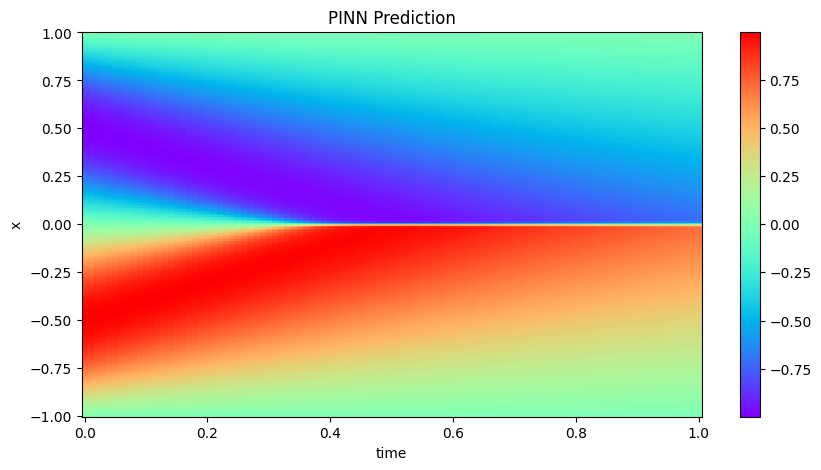

In [28]:
## Create plot
n, m = 101, 256
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)

XX,TT = np.meshgrid(X,T)
XX = XX.reshape(1,m*n)
TT = TT.reshape(1,m*n)

input1 = np.array([XX[0],TT[0]]).T
#print(np.array([X,T]))
u_pred = model.predict(input1)
u_pred = u_pred.reshape(n, m)
u_pred.shape

plt.subplots(figsize=(10,5))
c = plt.pcolormesh(T,X, u_pred.T,cmap='rainbow')
plt.colorbar(c)
plt.xlabel('time')
plt.ylabel('x')
plt.title("PINN Prediction")